# Predição e Classificação de Pacientes com Diabetes

Nesse projeto vamos usar uma base de dados disponível no Kaggle.

Aqui o objetivo é predizer se pacientes terão ou não diabetes de acordo com suas características (features). Como a variável a ser predita é categórica, modelaremos nosso problema como uma <b>classificação</b>.

In [1]:
# Importando os pacotes necessários:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Importando as bibliotecas do scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [5]:
# Carregando a base de dados:
pacientes = pd.read_csv('C:\\data_science\\projeto-predicao-diabetes\\diabetes.csv')
pacientes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Percebe-se que todas as variáveis são numéricas, logo, não será necessária a codificação.

In [7]:
# Renomeando as colunas:
pacientes.columns = ['num_gravidez', 'glicose', 'pressao_sanguinea', 'espessura_pele', 'insulina',
                    'imc', 'teste_tolerancia_glicose', 'idade','tem_diabetes']
pacientes.head()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade,tem_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
pacientes.shape

(768, 9)

Temos 768 pacientes na base de dados. 8 features e 1 variável target (tem_diabetes).

In [11]:
# Verificando a distribuição da target:
pacientes['tem_diabetes'].value_counts()

tem_diabetes
0    500
1    268
Name: count, dtype: int64

In [13]:
# Acurácia Base (chutar que qualquer paciente não terá diabetes)
500/768

0.6510416666666666

<b>Logo, nosso modelo campeão precisa de uma acurácia no mínimo maior que 65.1%</b>

In [15]:
pacientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_gravidez              768 non-null    int64  
 1   glicose                   768 non-null    int64  
 2   pressao_sanguinea         768 non-null    int64  
 3   espessura_pele            768 non-null    int64  
 4   insulina                  768 non-null    int64  
 5   imc                       768 non-null    float64
 6   teste_tolerancia_glicose  768 non-null    float64
 7   idade                     768 non-null    int64  
 8   tem_diabetes              768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Todas as features são numéricas, e não temos valores nulos. Logo, não precisamos fazer o tratamento de <i>missing data</i>.

In [17]:
pacientes.isnull().sum()

num_gravidez                0
glicose                     0
pressao_sanguinea           0
espessura_pele              0
insulina                    0
imc                         0
teste_tolerancia_glicose    0
idade                       0
tem_diabetes                0
dtype: int64

In [19]:
# Fazendo uma AED rápida das features:
pacientes.describe()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade,tem_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Temos alguns problemas, além de outliers. Ter um número minimo 0 para esses indicadores médicos quer dizer que temos sim valores nulos que não apareceram nas verificações anteriores.

In [21]:
glicose_zero = pacientes.loc[pacientes['glicose'] == 0]
glicose_zero.shape

(5, 9)

In [23]:
pressao_zero = pacientes.loc[pacientes['pressao_sanguinea'] == 0]
pressao_zero.shape

(35, 9)

In [25]:
imc_zero = pacientes.loc[pacientes['imc'] == 0]
imc_zero.shape

(11, 9)

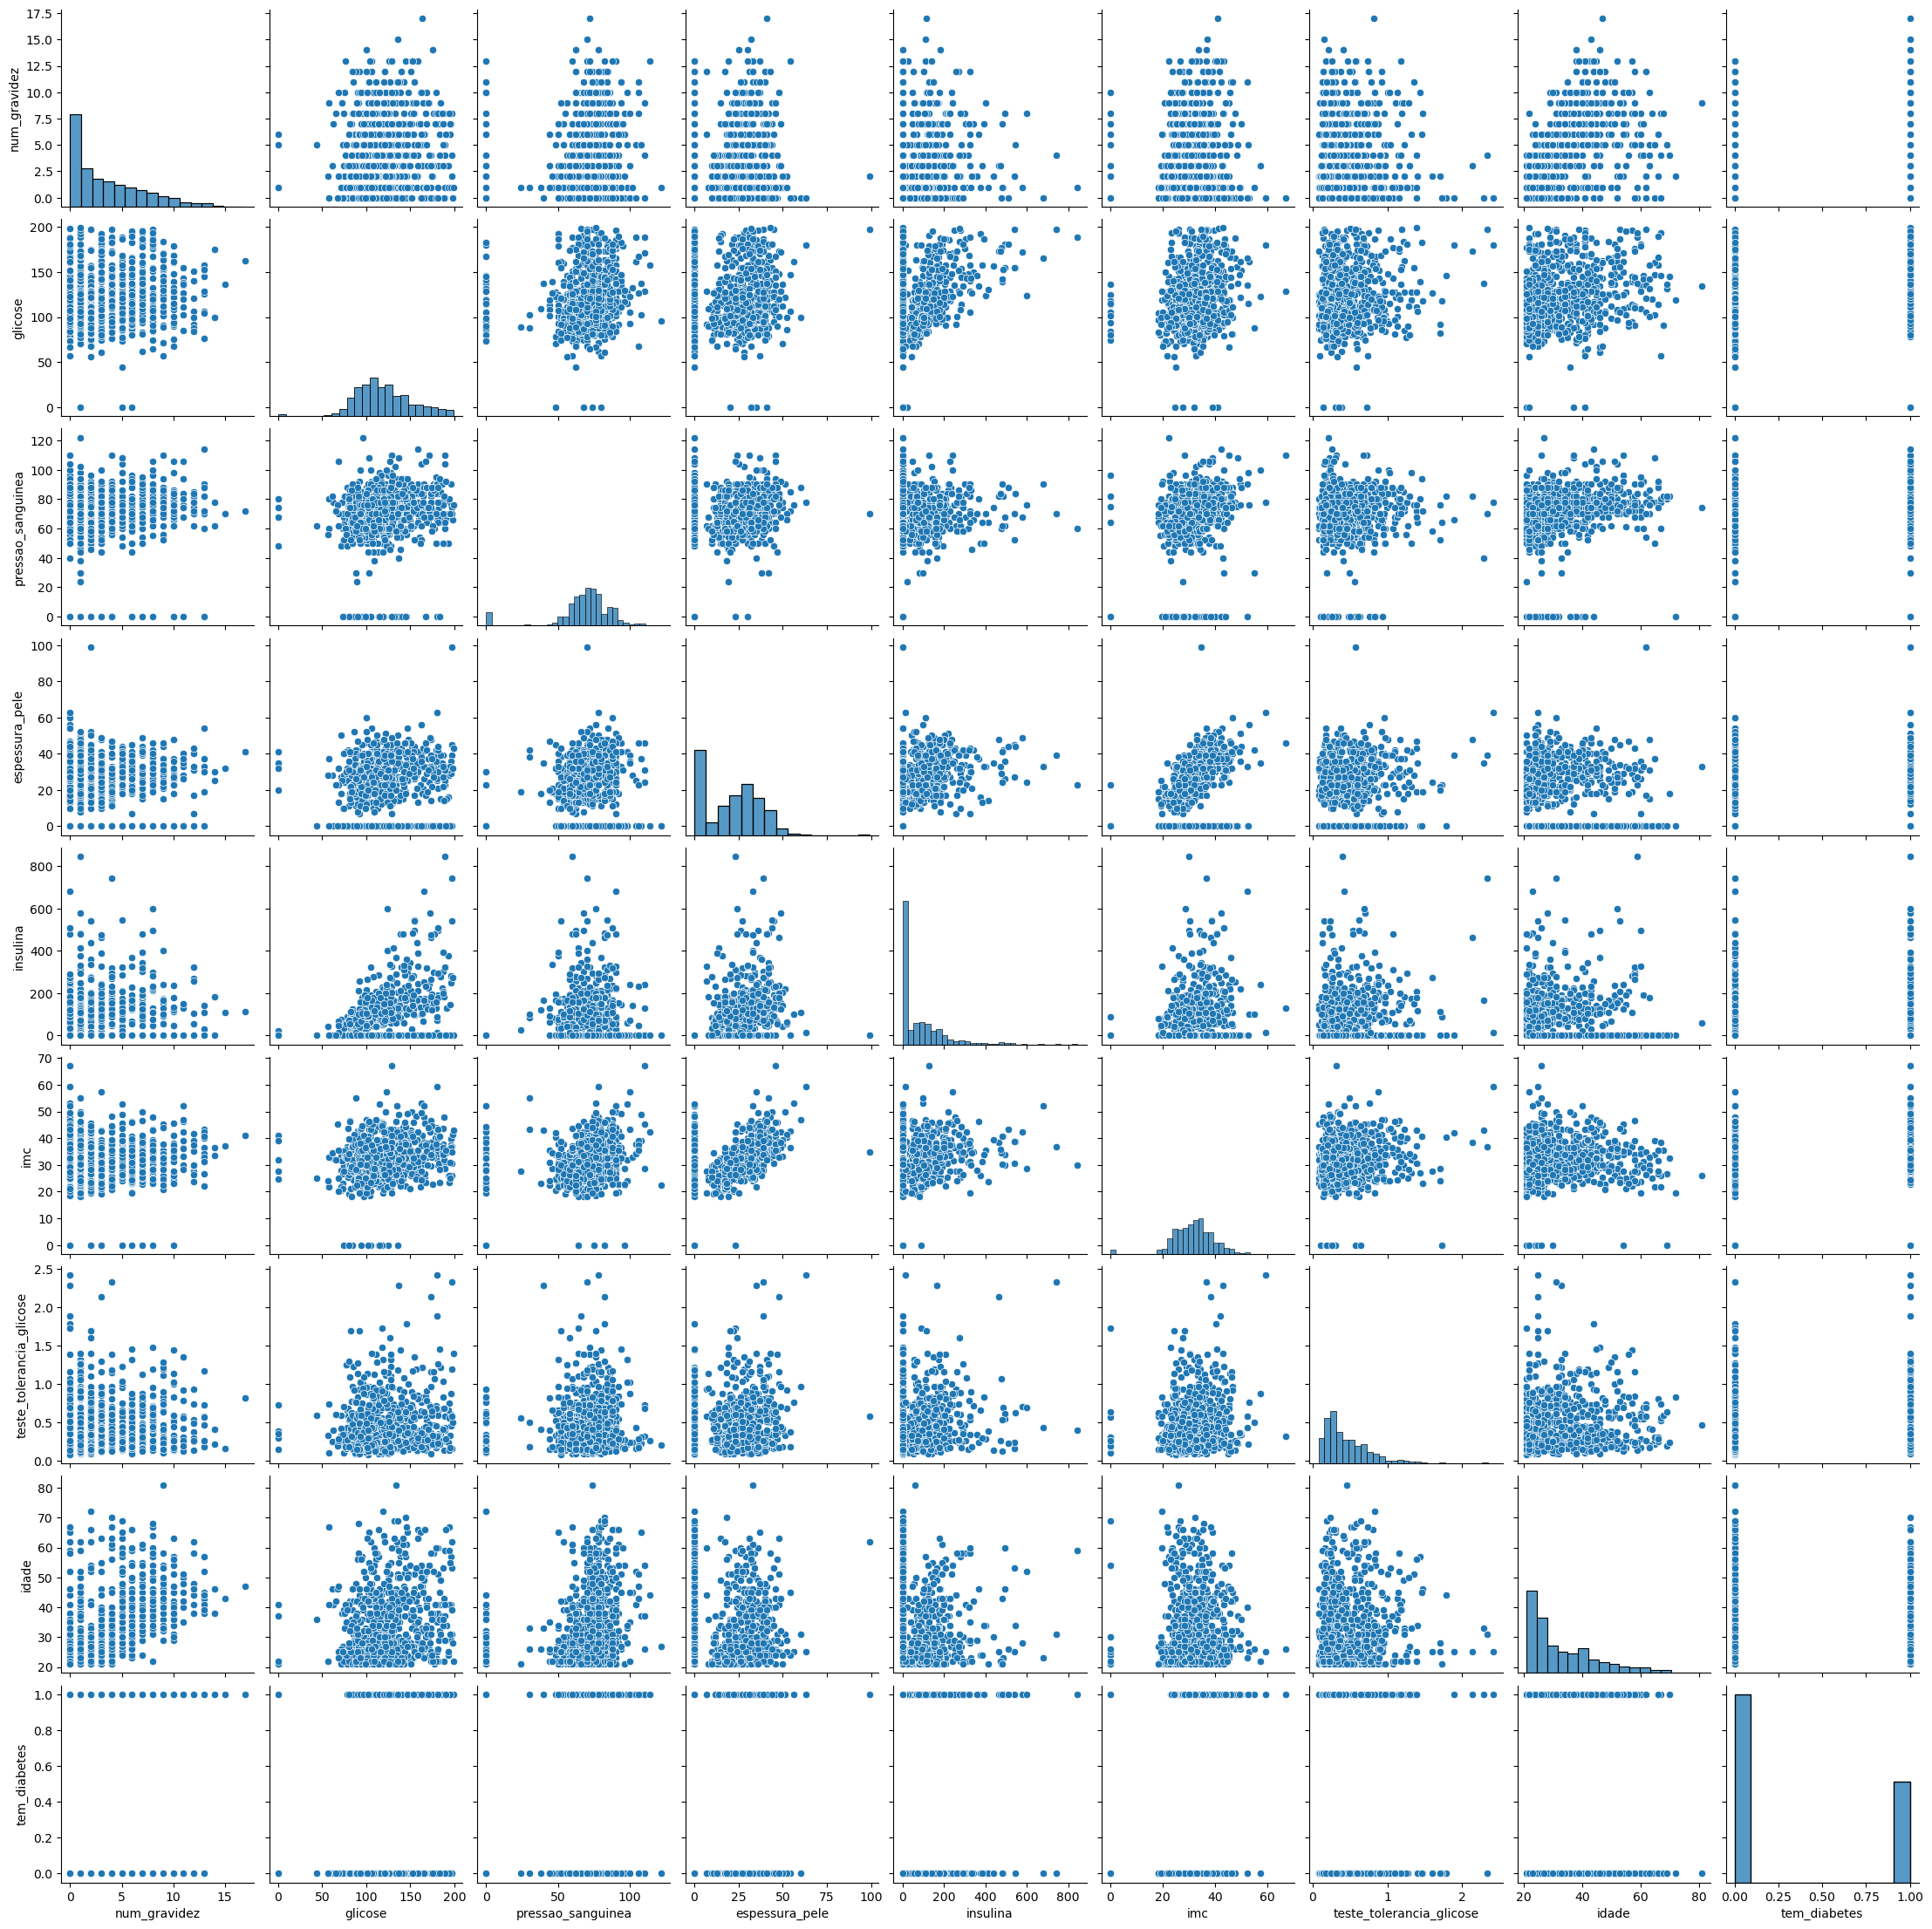

In [27]:
# Plotando um pairplot para verificar se existe alguma relação entre features:
sns.pairplot(pacientes)

## Separando a variável Target e as Features

In [29]:
X = pacientes.drop(['tem_diabetes'], axis=1)
y = pacientes['tem_diabetes']
X.shape, y.shape

((768, 8), (768,))

In [31]:
X.head()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [33]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: tem_diabetes, dtype: int64

## Separação de Bases

Antes de qualquer tratamento vamos fazer o split em bases de treino e teste. Isso evita data leakage e overfitting do modelo preditivo.

In [35]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.1, random_state=42)
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((691, 8), (77, 8), (691,), (77,))

# Tratamento de outliers, missing data e feature scalling

<Axes: >

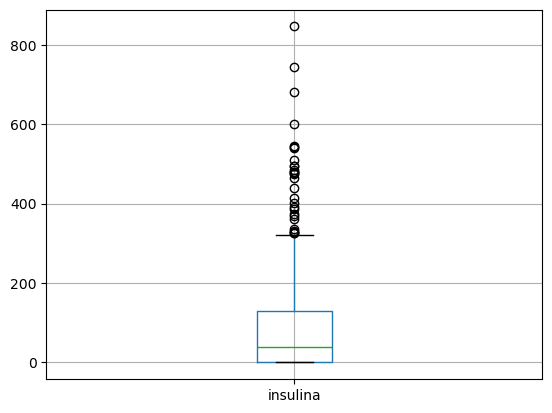

In [37]:
# Plotando um boxplot da base de treino para verificar a existência de outliers
# Aqui faremos na insulina primeiro:
X_treino[['insulina']].boxplot()

In [39]:
# Calculando o Intervalo Interquartilico:
quartil_1 = X_treino['insulina'].describe()['25%']
quartil_3 = X_treino['insulina'].describe()['75%']

iiq = quartil_3 - quartil_1
iiq

129.5

In [41]:
# Determinando os outliers para cima e para baixo:
outlier_abaixo = quartil_1 - (1.5*iiq)
outlier_acima = quartil_3 + (1.5*iiq)

outlier_abaixo, outlier_acima

(-194.25, 323.75)

Logo, não existem outliers para baixo, pois é impossível ter insulina negativa. Logo, só existem outliers acima a serem removidos.

In [43]:
# Removendo os outliers:
X_treino_2 = X_treino.loc[X_treino['insulina'] < outlier_acima]
X_treino_2.shape

(662, 8)

Removemos apenas os outliers da insulina. Vamos verificar agora os valores zerados para espessura de pele.

<Axes: >

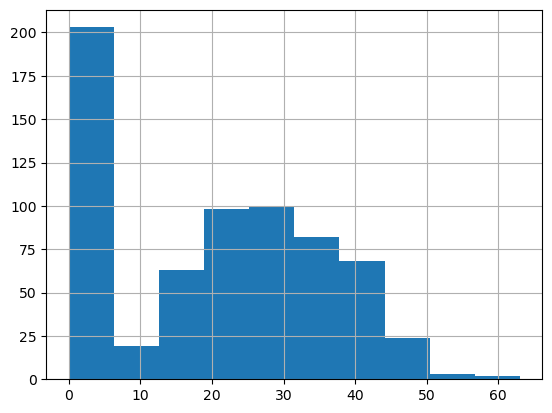

In [45]:
X_treino_2['espessura_pele'].hist()

In [47]:
media_espessura_treino = X_treino_2.loc[X_treino_2['espessura_pele'] > 0, 'espessura_pele'].mean()
media_espessura_treino

28.74074074074074

C:\Users\rhyan\AppData\Local\Temp\ipykernel_5656\4045776621.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.74074074074074' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_treino_2.loc[X_treino_2['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_treino


<Axes: >

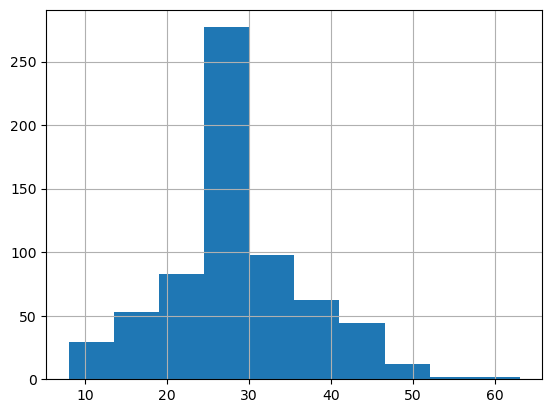

In [49]:
# Substituindo os valores zerados pela média:
X_treino_2.loc[X_treino_2['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_treino
X_treino_2['espessura_pele'].hist()

C:\Users\rhyan\AppData\Local\Temp\ipykernel_5656\518379097.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.74074074074074' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_teste.loc[X_teste['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_treino


<Axes: >

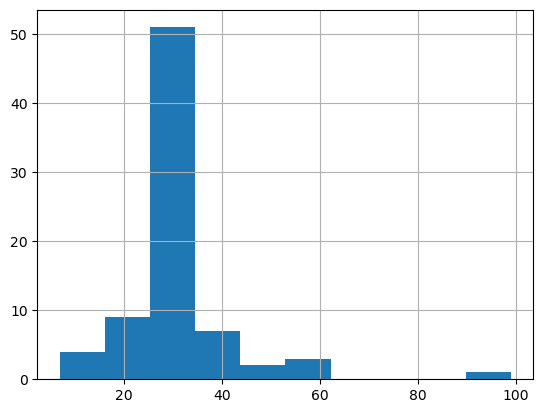

In [51]:
X_teste.loc[X_teste['espessura_pele'] == 0, 'espessura_pele'] = media_espessura_treino
X_teste['espessura_pele'].hist()

In [53]:
# Tratados os outliers e removidos os zeros vamos:
X_treino_2.describe()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
count,662.00000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,3.81571,119.157100,69.049849,28.740741,63.345921,31.839426,0.469672,32.714502
std,3.38134,31.350772,19.370086,8.330371,79.037858,7.927699,0.324974,11.298926
min,0.00000,0.000000,0.000000,8.000000,0.000000,0.000000,0.078000,21.000000
25%,1.00000,99.000000,62.000000,25.000000,0.000000,27.000000,0.245000,24.000000
50%,3.00000,115.500000,72.000000,28.740741,7.000000,32.000000,0.378000,29.000000
75%,6.00000,137.000000,80.000000,32.000000,115.000000,36.375000,0.621500,40.000000
max,17.00000,199.000000,122.000000,63.000000,321.000000,67.100000,2.420000,81.000000


Precisamos fazer o mesmo para pressao_sanguinea e imc.

<Axes: >

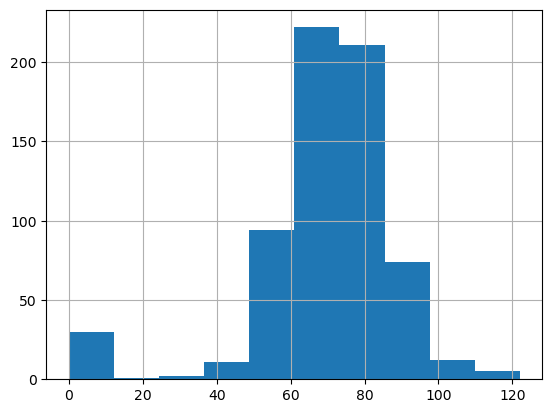

In [55]:
# Começando pela pressão sanguínea:
X_treino_2['pressao_sanguinea'].hist()

In [57]:
media_pressao_treino = X_treino_2.loc[X_treino_2['pressao_sanguinea'] > 0, 'pressao_sanguinea'].mean()
media_pressao_treino

72.32753164556962

C:\Users\rhyan\AppData\Local\Temp\ipykernel_5656\2907107140.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.32753164556962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_treino_2.loc[X_treino_2['pressao_sanguinea'] == 0, 'pressao_sanguinea'] = media_pressao_treino


<Axes: >

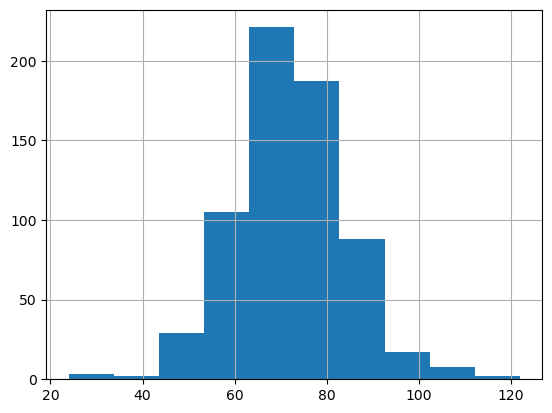

In [59]:
# Substituindo os valores zerados pela média:
X_treino_2.loc[X_treino_2['pressao_sanguinea'] == 0, 'pressao_sanguinea'] = media_pressao_treino
X_treino_2['pressao_sanguinea'].hist()

C:\Users\rhyan\AppData\Local\Temp\ipykernel_5656\2943756876.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.32753164556962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_teste.loc[X_teste['pressao_sanguinea'] == 0, 'pressao_sanguinea'] = media_pressao_treino


<Axes: >

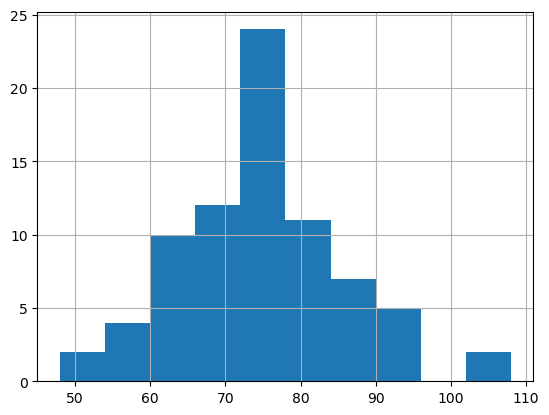

In [61]:
X_teste.loc[X_teste['pressao_sanguinea'] == 0, 'pressao_sanguinea'] = media_pressao_treino
X_teste['pressao_sanguinea'].hist()

In [63]:
X_treino_2.describe()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
count,662.00000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,3.81571,119.157100,72.327532,28.740741,63.345921,31.839426,0.469672,32.714502
std,3.38134,31.350772,12.187467,8.330371,79.037858,7.927699,0.324974,11.298926
min,0.00000,0.000000,24.000000,8.000000,0.000000,0.000000,0.078000,21.000000
25%,1.00000,99.000000,64.000000,25.000000,0.000000,27.000000,0.245000,24.000000
50%,3.00000,115.500000,72.327532,28.740741,7.000000,32.000000,0.378000,29.000000
75%,6.00000,137.000000,80.000000,32.000000,115.000000,36.375000,0.621500,40.000000
max,17.00000,199.000000,122.000000,63.000000,321.000000,67.100000,2.420000,81.000000


<Axes: >

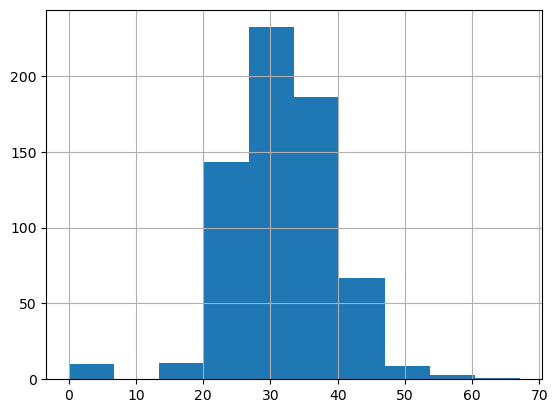

In [65]:
# Finalmente, para o IMC:
X_treino_2['imc'].hist()

In [67]:
media_imc_treino = X_treino_2.loc[X_treino_2['imc'] > 0, 'imc'].mean()
media_imc_treino

32.32776073619632

<Axes: >

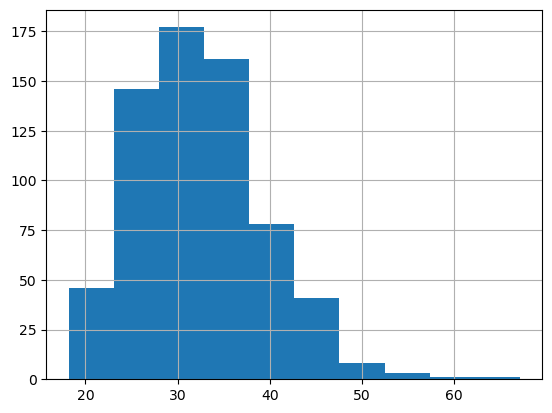

In [69]:
# Substituindo os valores zerados pela média:
X_treino_2.loc[X_treino_2['imc'] == 0, 'imc'] = media_imc_treino
X_treino_2['imc'].hist()

<Axes: >

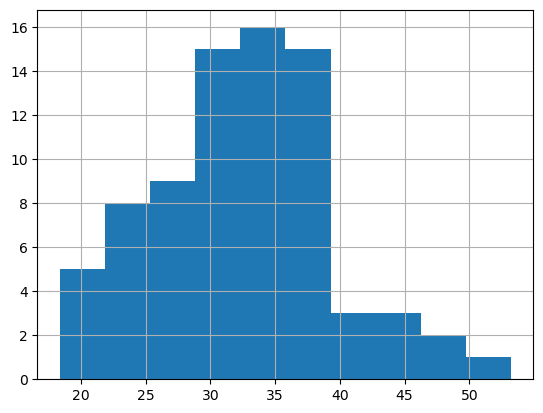

In [71]:
X_teste.loc[X_teste['imc'] == 0, 'imc'] = media_imc_treino
X_teste['imc'].hist()

In [73]:
X_treino_2.describe()

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
count,662.00000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,3.81571,119.157100,72.327532,28.740741,63.345921,32.327761,0.469672,32.714502
std,3.38134,31.350772,12.187467,8.330371,79.037858,6.875798,0.324974,11.298926
min,0.00000,0.000000,24.000000,8.000000,0.000000,18.200000,0.078000,21.000000
25%,1.00000,99.000000,64.000000,25.000000,0.000000,27.325000,0.245000,24.000000
50%,3.00000,115.500000,72.327532,28.740741,7.000000,32.300000,0.378000,29.000000
75%,6.00000,137.000000,80.000000,32.000000,115.000000,36.375000,0.621500,40.000000
max,17.00000,199.000000,122.000000,63.000000,321.000000,67.100000,2.420000,81.000000


In [75]:
# Utilizando um scaler para igualar as grandezas das features:
scaler = StandardScaler()
X_treino_escalado = scaler.fit_transform(X_treino_2)
X_teste_escalado = scaler.transform(X_teste)

In [77]:
X_treino_escalado

array([[-0.24142109, -0.7392038 , -1.34071157, ..., -1.11020261,
         1.46069111,  0.55671233],
       [-1.12931422, -0.06885734, -0.51957608, ..., -0.22236198,
         0.07183788, -0.94899317],
       [ 0.05454328, -0.29230616,  1.6153762 , ...,  0.76736201,
        -0.85817027, -0.24042587],
       ...,
       [ 1.83032954, -0.5795975 ,  1.1226949 , ...,  1.93174317,
         2.05195457,  0.46814142],
       [-1.12931422,  0.6972529 ,  0.        , ...,  1.4659907 ,
        -0.81505731, -0.32899679],
       [-1.12931422,  0.18651274,  1.9438304 , ..., -1.43040743,
        -0.63952597, -1.03756408]])

## Machine Learning

Nosso primeiro modelo será o <b>Support Vector Machines</b>

In [88]:
# Criando o modelo:
classificador = svm.SVC(kernel='linear')

# Validando o modelo com cross_validation:
valores_svm = cross_val_score(estimator=classificador, X=X_treino,y=y_treino, cv=10, scoring='accuracy')
valores_svm

array([0.81428571, 0.73913043, 0.76811594, 0.85507246, 0.72463768,
       0.73913043, 0.86956522, 0.69565217, 0.7826087 , 0.7826087 ])

In [90]:
valores_svm.mean()

0.7770807453416149

<b>Tivemos uma acurácia de 77.7% que é superior a 65.1%. Logo nosso modelo svm é superior à simplesmente chutar que nenhum paciente terá diabetes.</b>

Nosso próximo modelo a ser treinado é o <b>Random Forest</b>

In [94]:
# Criando o modelo:
random_forest = RandomForestClassifier()

# Validação com cross-validation:
valores_rf = cross_val_score(estimator=random_forest, X=X_treino, y=y_treino, cv=10, scoring='accuracy')
valores_rf

array([0.74285714, 0.76811594, 0.76811594, 0.85507246, 0.72463768,
       0.72463768, 0.84057971, 0.69565217, 0.75362319, 0.7826087 ])

In [96]:
valores_rf.mean()

0.7655900621118013

<b>O Random Forest também foi superior ao "chute", 76.6% > 65.1%. Porém, o modelo SVM ainda foi melhor, sendo assim o nosso modelo campeão!</b>

## Treinando e Testando o Modelo Campeão

In [100]:
classificador.fit(X_treino, y_treino)

SVC(kernel='linear')

In [110]:
# Verificando os coeficientes:
classificador.coef_

array([[ 0.07509867,  0.02901319, -0.01234793, -0.00110019, -0.00113896,
         0.0728654 ,  0.59880295,  0.02216913]])

In [113]:
coeficientes = classificador.coef_.reshape(1, -1) if classificador.coef_.ndim == 1 else classificador.coef_

# Criando o DataFrame para armazenar os coeficientes:
df_coeficientes = pd.DataFrame(coeficientes, columns=classificador.feature_names_in_)
df_coeficientes

,num_gravidez,glicose,pressao_sanguinea,espessura_pele,insulina,imc,teste_tolerancia_glicose,idade
0,0.075099,0.029013,-0.012348,-0.0011,-0.001139,0.072865,0.598803,0.022169


## Cálculo do p-valor

O p-valor vai nos dizer se os coeficientes são estatisticamente válidos.

In [118]:
!pip install statsmodels

In [121]:
import statsmodels.api as sm

In [128]:
# Configurando o pandas para não mostrar a notação científica:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [130]:
# Vamos calcular o p-valor
r2_statsmodels = sm.OLS(y_treino, X_treino)
resultado_fit = r2_statsmodels.fit()
p_valores = resultado_fit.summary2().tables[1]['P>|t|']
p_valores

num_gravidez               0.00
glicose                    0.00
pressao_sanguinea          0.00
espessura_pele             0.95
insulina                   0.89
imc                        0.08
teste_tolerancia_glicose   0.06
idade                      0.72
Name: P>|t|, dtype: float64

A maioria dos coeficientes tem um p-valor superior a 0.05. Esse problema é porque fizemos o tratamento depois do split, o que está errado.

In [134]:
# Fazendo previsões na base de teste:
predicoes = classificador.predict(X_teste)

In [144]:
# Vamos usar nosso modelo para predizer as charges da base de teste:
diabetes_preditos = classificador.predict(X_teste)
diabetes_preditos[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [140]:
y_teste.head()

668    0
324    0
624    0
690    0
473    0
Name: tem_diabetes, dtype: int64

Acertamos todas as primeiras 5 predições. Vamos ver o restante.

In [146]:
predicoes_vs_reais = pd.DataFrame({'predicao': diabetes_preditos.flatten(), 'real': y_teste.values.flatten()})
predicoes_vs_reais['diferenca_abs'] = abs(predicoes_vs_reais['predicao'] - predicoes_vs_reais['real'])
predicoes_vs_reais.head(20)

,predicao,real,diferenca_abs
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,1,0,1
9,1,0,1


In [148]:
# Vendo a acurácia das predições:
error_score = accuracy_score(y_teste, predicoes)
print("Acurácia : ", error_score)

Acurácia :  0.7012987012987013
